In [15]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install tensorflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

# As the dataset is divided into folders
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Creating Dataset

In [28]:
w,h = 400,400
batch_size = 32

train_path = 'lung/train'
test_path = 'lung/test'
val_path = 'lung/valid'

train_img_gen = ImageDataGenerator(
    rescale = 1.0/255,
    zoom_range=0.3
)

test_img_gen = ImageDataGenerator(
    rescale = 1.0/255
)

val_img_gen = ImageDataGenerator(
    rescale = 1.0/255
)

train_dataset = train_img_gen.flow_from_directory(
    train_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_dataset = test_img_gen.flow_from_directory(
    test_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_dataset = val_img_gen.flow_from_directory(
    val_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lung/train'

In [27]:
train_dataset.class_indices

NameError: name 'train_dataset' is not defined

# View Images

In [26]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TB']

for _ in range(5):
    img, label = train_dataset.__next__()
    print(img.shape)
    plt.title(classes[np.argmax(label[0])])
    plt.imshow(img[0])
    plt.show()

NameError: name 'train_dataset' is not defined

In [6]:
train_dataset.image_shape

(400, 400, 3)

# DCNN

In [7]:
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(w, h, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # dropout to avoid overfitting
model.add(layers.Dense(4, activation='softmax'))  # softmax is used as it is a multiclass problem

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 398, 398, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 199, 199, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 197, 197, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 98, 98, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 96, 96, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 294912)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      37,748,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,861,956 (144.43 MB)

 Trainable params: 37,861,956 (144.43 MB)

 Non-trainable params: 0 (0.00 B)

# ResNet101_v2

In [8]:
resnetModel = models.Sequential()

ResNet_101_V2 = tf.keras.applications.ResNet101V2(
                include_top = False,
                weights="imagenet",
                input_shape=(w,h,3),
                pooling='max',
                classes=4
            )

for layer in ResNet_101_V2.layers:
    layer.trainable = False

resnetModel.add(ResNet_101_V2)
resnetModel.add(layers.Flatten())
resnetModel.add(layers.Dense(512, activation='relu'))
resnetModel.add(layers.Dense(4, activation='softmax'))  # softmax is used as it is a multiclass problem

# Compile the model
resnetModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

resnetModel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 2048)                │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,677,700 (166.62 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 42,626,560 (162.61 MB)

In [9]:
# Save best model
weight_path = 'best_model.weights.h5'

model_checkpoint = ModelCheckpoint(
    filepath = weight_path,
    save_best_only = True,
    save_weights_only = True,
    mode = 'max',
    monitor = 'val_accuracy'
) 

In [10]:
history = resnetModel.fit(train_dataset, epochs=15, validation_data=val_dataset, callbacks=[model_checkpoint])

Epoch 1/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 1347s 4s/step - accuracy: 0.7381 - loss: 5.5975 - val_accuracy: 0.8808 - val_loss: 0.3503
Epoch 2/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 1342s 4s/step - accuracy: 0.8626 - loss: 0.3949 - val_accuracy: 0.8703 - val_loss: 0.3217
Epoch 3/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 1309s 3s/step - accuracy: 0.8856 - loss: 0.2970 - val_accuracy: 0.9065 - val_loss: 0.2296
Epoch 4/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 1289s 3s/step - accuracy: 0.8950 - loss: 0.2775 - val_accuracy: 0.9035 - val_loss: 0.2474
Epoch 5/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 1285s 3s/step - accuracy: 0.9053 - loss: 0.2387 - val_accuracy: 0.9095 - val_loss: 0.2257
Epoch 6/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 1289s 3s/step - accuracy: 0.9088 - loss: 0.2413 - val_accuracy: 0.9216 - val_loss: 0.1822
Epoch 7/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 1288s 3s/step - accuracy: 0.9151 - loss: 0.2265 - val_accuracy: 0.9186 - val_loss: 0.1782
Epoch 8/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 1277s 3s/step - accuracy: 0.9096 - loss: 0.2385 - 

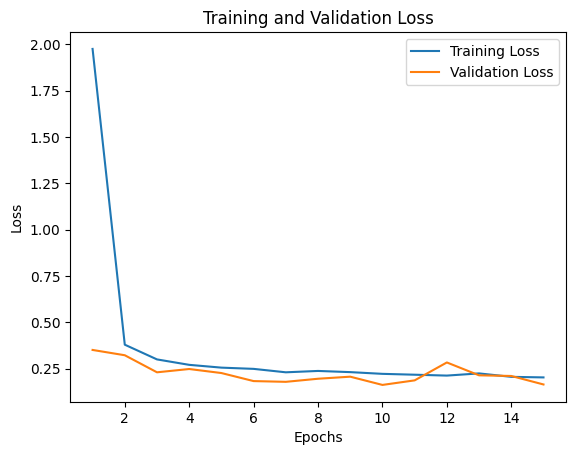

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(history.history['loss'])
# Plot the loss and val_loss
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [21]:
resnetModel.save('final_model.h5')

# Predictions

In [22]:
# load best weights to model
resnetModel.load_weights(weight_path)

# make predictions
predictions = resnetModel.predict(test_dataset)
predictions

63/63 ━━━━━━━━━━━━━━━━━━━━ 1092s 17s/step


array([[9.9884880e-01, 2.1885562e-06, 3.3546858e-05, 1.1154610e-03],
       [5.8078086e-01, 1.0071252e-02, 4.0772468e-01, 1.4231466e-03],
       [5.5344909e-01, 1.2898373e-03, 1.7125387e-02, 4.2813569e-01],
       ...,
       [7.1860952e-05, 3.6887280e-07, 5.0111566e-07, 9.9992728e-01],
       [4.7515977e-07, 2.2968056e-08, 1.1769837e-07, 9.9999940e-01],
       [9.4595169e-05, 3.1959679e-08, 2.4538272e-06, 9.9990296e-01]],
      dtype=float32)

In [23]:
# we have to get the position of the maximum value from each sample.

predicted_class = np.argmax(predictions, axis=1)

In [24]:
!pip install scikit-learn

              precision    recall  f1-score   support

           0       0.75      0.96      0.84        46
           1       0.81      0.90      0.85       414
           2       0.97      0.93      0.95      1317
           3       1.00      0.97      0.98       223

    accuracy                           0.93      2000
   macro avg       0.88      0.94      0.91      2000
weighted avg       0.93      0.93      0.93      2000

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}


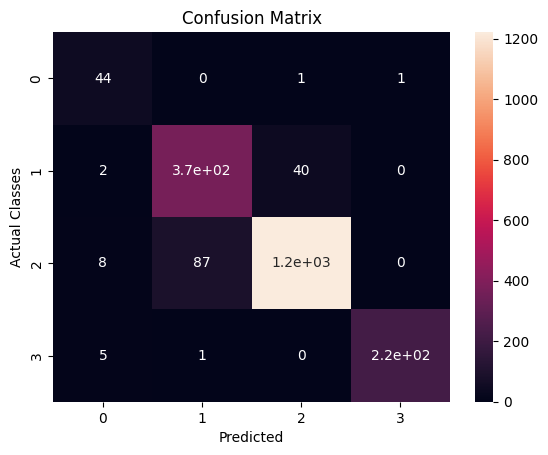

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

true_labels = test_dataset.classes

sns.heatmap(confusion_matrix(true_labels, predicted_class), annot=True)

# Print classification report
print(classification_report(true_labels, predicted_class))
print(test_dataset.class_indices)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

In [26]:
!pip install ipywidgets

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Class : COVID19
Confidence Score : 99.94714856147766%


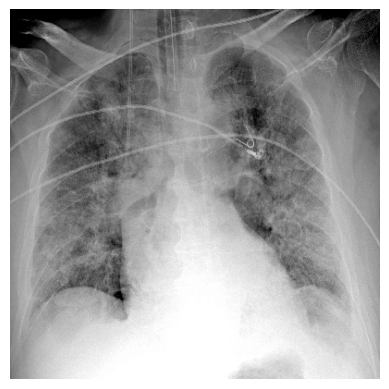

In [33]:
import keras.utils as image

# Path ไปยังภาพที่ต้องการทำนาย
img_path = 'C:/Users/user/Desktop/MEDUCATION/covid-19.jpg' 

# โหลดภาพและปรับขนาด
img = image.load_img(img_path, target_size=(400, 400))

# แปลงภาพเป็น array และ normalize
x = image.img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)

# ทำนายผลลัพธ์
preds = model.predict(x)

# หาคลาสที่มีค่าความมั่นใจสูงสุด
pred_class = np.argmax(preds)  # find maximum confident value in output layer
print('Class : ' + str(class_labels[pred_class])) # pred_class is index node of maximum confident value
print('Confidence Score : ' + str(np.max(preds)*100) + '%')

# แสดงภาพที่ทำการทำนาย
plt.imshow(img)
plt.axis('off')  # ปิดการแสดงแกน
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Class : COVID19
Confidence Score : 99.95%


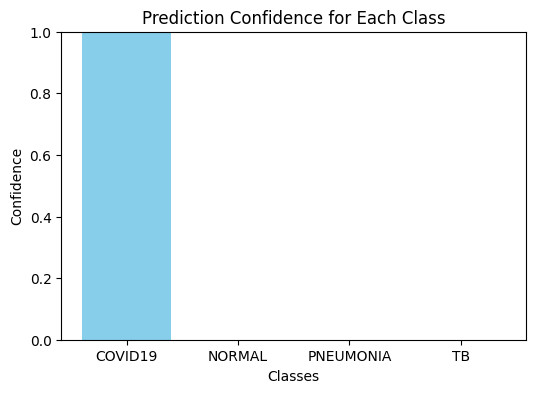

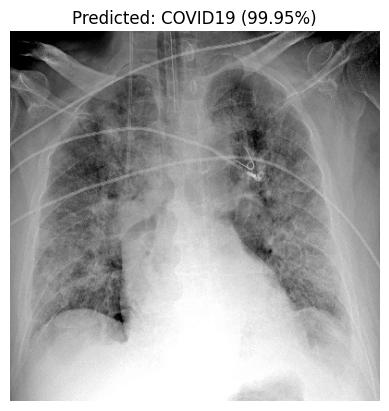

In [1]:
import numpy as np
import tensorflow as tf
import keras.utils as image
import matplotlib.pyplot as plt
import os

# ตรวจสอบว่าไฟล์โมเดลมีอยู่จริงหรือไม่
model_path = 'C:/Users/user/Desktop/MEDUCATION/final_model.h5'
if not os.path.exists(model_path):
    print(f"Error: Model file '{model_path}' not found!")
    exit()

# โหลดโมเดลที่ฝึกแล้ว
model = tf.keras.models.load_model(model_path)

# คลาสที่โมเดลจะทำนาย
class_labels = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TB']

# Path ไปยังภาพที่ต้องการทำนาย
img_path = 'C:/Users/user/Desktop/MEDUCATION/covid-19.jpg'

# ตรวจสอบว่าไฟล์ภาพมีอยู่จริงหรือไม่
if not os.path.exists(img_path):
    print(f"Error: Image file '{img_path}' not found!")
    exit()

# โหลดภาพและปรับขนาด
img = image.load_img(img_path, target_size=(400, 400))

# แปลงภาพเป็น array และ normalize
x = image.img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)

# ทำนายผลลัพธ์
preds = model.predict(x)

# หาคลาสที่มีค่าความมั่นใจสูงสุด
pred_class = np.argmax(preds)
confidence = np.max(preds) * 100

# แสดงผลลัพธ์
print(f'Class : {class_labels[pred_class]}')  # แสดงชื่อคลาสที่ทำนาย
print(f'Confidence Score : {confidence:.2f}%')  # แสดงความมั่นใจในผลลัพธ์

# แสดงกราฟของการทำนายในแต่ละคลาส
plt.figure(figsize=(6, 4))
plt.bar(class_labels, preds[0], color='skyblue')
plt.title('Prediction Confidence for Each Class')
plt.xlabel('Classes')
plt.ylabel('Confidence')
plt.ylim(0, 1)
plt.show()

# แสดงภาพที่ทำการทำนาย
plt.imshow(img)
plt.axis('off')  # ปิดการแสดงแกน
plt.title(f"Predicted: {class_labels[pred_class]} ({confidence:.2f}%)")
plt.show()
